## 3. This notebook explores use of Deep Learning Models to predict text difficulty: 

1. Here, we used Simple NN structure w/o GridsearchCV
2. And CNN with Bidirectional GRU along with attention layer.
        a. CNN-BiGRU with attention helps to improve text classification as per article cited below. 
        Please see reference below.
        
https://www.researchgate.net/publication/329189864_A_Bi-Directional_LSTM-CNN_Model_with_Attention_for_Aspect-Level_Text_Classification 

I just wanted to try it out with two differnt tokenizers  (keras text tokenizer and sentence piece tokenizer) to evaluate the difference in model performance. Some models took longer run time, hence I tried to limit the scope of the model architecture. 

#### Train and test accuracy ranged between 75% to 70% approximately.  

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, MaxPooling1D, GRU, Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# fix random seed for reproducibility
np.random.seed(0)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqWeightedAttention
import sentencepiece as spm
from functools import lru_cache

Using TensorFlow backend.


## 1.Build simple NN model: Architecture

#### A. Using extracted features in tabular form:
1. Approach 1: GridsearchCV hyperparameters & Estimate Mean Accuracy using cv = 3. 
      - But it doe snot support Early Stopping to save computational resources. 
      
      
2. Approach 2: Estimate Accuracy Score with validation_split= 20%. 
      - But it does not allow a way to use cross_val_score or GridSearchCV. 

#### Approach 1: Using GridSerachCV

In [2]:
# Get feature set: 
features = pd.read_csv('extracted_train_features_with_stopwords_pca.csv')
features.iloc[:,6:].head()

,english,pca1,pca2,pca3,pca4,pca5,pca6,count_lemma_85_above,count_lemma_85_below,PRON,...,CCONJ,ADJ,NUM,X,INTJ,SYM,nsyll,sent_length,count_unk,avg_wrd_len
0,1,-1.241217,0.088320,-0.179642,-0.222200,-1.284015,-0.170834,21,0,1.0,...,3.0,1.0,0.0,0.0,0.0,0.0,58,35,6,4.485714
1,1,-0.709833,0.029789,-0.094246,-0.031762,-0.808466,-0.026293,13,0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,45,22,8,5.818182
2,1,-1.476741,0.121393,-0.185596,-0.338178,-1.535181,-0.191979,28,0,3.0,...,1.0,0.0,2.0,0.0,0.0,0.0,66,42,6,4.642857
3,1,0.725988,-0.165156,0.217168,0.232158,-0.917349,-0.221426,26,0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,64,32,2,6.281250
4,1,-0.792123,-0.048933,0.170466,0.261691,-0.101480,0.524189,12,1,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,42,31,6,4.612903


In [3]:
# Select number of neurons in dense layer: 
# Use formula: Source Stakoverflow and it seems to work well. 
# N = Number of observations/(alpha * (Number of input features + Number of output features))
# Alpha can be anywhere between 2 to 9

N = 332991/(2*32)
print(N)

5202.984375


In [4]:
@lru_cache(128)
def create_simple_NN():
    
    
    # Create Sequential model: 
    model_grid = Sequential()
    
    # add layers: 

    # normalize
    model_grid.add(BatchNormalization(input_shape = (30,)))

    # hidden layer with dropout
    model_grid.add(Dense(1000, kernel_initializer='normal', activation='relu', input_shape= (30,) ))
    model_grid.add(Dropout(0.1))

    # hidden layer with dropout
    model_grid.add(Dense(500, kernel_initializer='normal', activation='relu'))
    model_grid.add(Dropout(0.2))

    # hidden layer with dropout
    model_grid.add(Dense(1000, kernel_initializer='normal',  activation='relu'))
    model_grid.add(Dropout(0.2))

    # hidden layer with dropout
    model_grid.add(Dense(500, kernel_initializer='normal', activation='relu'))
    model_grid.add(Dropout(0.2))

    # hidden layer 
    model_grid.add(Dense(500, kernel_initializer='normal', activation='relu'))

    # hidden layer 
    model_grid.add(Dense(1000, kernel_initializer='normal', activation='relu'))

    # hidden layer with dropout
    model_grid.add(Dense(1000, kernel_initializer='normal', activation='relu'))
    model_grid.add(Dropout(0.1))

    # output layer
    model_grid.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))  
    
    # compile model: 
    model_grid.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model_grid

In [5]:
# Get input features and target lables as dataframes: 
X = features.iloc[:,6:]
y = features.iloc[:,5]
print(X.shape, y.shape)

(416239, 30) (416239,)


In [6]:
# Build Model:

model_grid = KerasClassifier(build_fn=create_simple_NN, verbose = 0)
cv = StratifiedKFold(n_splits=3, shuffle=True,  random_state=0)

In [7]:
%%time
# Run GridSearchCV: 

# initiate Parameters
batch_sizes = [500, 1000]
epochs = [5, 8]
params = dict(epochs = epochs, batch_size = batch_sizes)

# initiate GridSearchCV with parameters:
grid_nn = GridSearchCV(estimator=model_grid, param_grid= params, scoring='accuracy', cv = cv, verbose=1, n_jobs=1)

# gridSearchCV result: 
# apply on 10 % data to get the parameters: 
grid_nn_result = grid_nn.fit(X.sample(frac=0.1).values, y.sample(frac=0.1).values)

# print Grid result with 10% data: 
print(grid_nn_result.best_params_, grid_nn_result.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  8.3min finished


{'batch_size': 1000, 'epochs': 8} 0.6337939369382356
CPU times: user 34min 3s, sys: 1min 34s, total: 35min 38s
Wall time: 9min 29s


In [8]:
# Simple NN network: 
create_simple_NN().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              31000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)             

In [9]:
%%time
# Checkpoint:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='nn_checkpoint', monitor='val_acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

# Using above grid serach parameters, we will fit simple NN model on the entire dataset
model_grid_parm = KerasClassifier(build_fn=create_simple_NN, epochs = 8 , batch_size = 1000 , verbose = 1)

# Estimate Cross val score
result = cross_val_score(model_grid_parm, X.values, y.values, cv = cv, scoring='accuracy', fit_params={'callbacks': callbacks_list})

Epoch 1/8
277492/277492 [==============================] - 59s 211us/step - loss: 0.6400 - accuracy: 0.6321

Epoch 00001: saving model to nn_checkpoint
Epoch 2/8
277492/277492 [==============================] - 63s 225us/step - loss: 0.6146 - accuracy: 0.6531

Epoch 00002: saving model to nn_checkpoint
Epoch 3/8
277492/277492 [==============================] - 62s 225us/step - loss: 0.6081 - accuracy: 0.6577

Epoch 00003: saving model to nn_checkpoint
Epoch 4/8
277492/277492 [==============================] - 64s 229us/step - loss: 0.6027 - accuracy: 0.6604

Epoch 00004: saving model to nn_checkpoint
Epoch 5/8
277492/277492 [==============================] - 62s 222us/step - loss: 0.5989 - accuracy: 0.6637

Epoch 00005: saving model to nn_checkpoint
Epoch 6/8
277492/277492 [==============================] - 63s 228us/step - loss: 0.5958 - accuracy: 0.6668

Epoch 00006: saving model to nn_checkpoint
Epoch 7/8
277492/277492 [==============================] - 66s 237us/step - loss: 0.5927

In [10]:
# Cross_val_score: 
result

array([0.66271703, 0.67441944, 0.68741441])

In [11]:
# Mean Accuracy: 
means = np.mean(result).round(3)
std = np.std(result).round(2)
print(f"NN Mean Accuracy and Standard Deviation: {means*100} %, ({std*100} %)" )

NN Mean Accuracy and Standard Deviation: 67.5 %, (1.0%)


#### Approach 2: Using train_test_split

In [12]:
# Train_test_Split: 
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, shuffle = True, random_state = 0)

In [13]:
%%time
# Initiate Sequential model: 
model_split = Sequential()
    
# Add layers: 

# normalize
model_split.add(BatchNormalization(input_shape = (30,)))

# hidden layer with dropout
model_split.add(Dense(1000, kernel_initializer='normal', activation='relu', input_shape= (30,) ))
model_split.add(Dropout(0.1))

# hidden layer with dropout
model_split.add(Dense(500, kernel_initializer='normal', activation='relu'))
model_split.add(Dropout(0.2))

# hidden layer with dropout
model_split.add(Dense(1000, kernel_initializer='normal',  activation='relu'))
model_split.add(Dropout(0.2))

# hidden layer with dropout
model_split.add(Dense(500, kernel_initializer='normal', activation='relu'))
model_split.add(Dropout(0.2))

# hidden layer 
model_split.add(Dense(500, kernel_initializer='normal', activation='relu'))

# hidden layer 
model_split.add(Dense(1000, kernel_initializer='normal', activation='relu'))

# hidden layer with dropout
model_split.add(Dense(1000, kernel_initializer='normal', activation='relu'))
model_split.add(Dropout(0.1))

# output layer
model_split.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))  
    
# compile model: 
model_split.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model_split.summary())

# add callback: 
call_back=EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


# fit model: 
non_grid_nn = model_split.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=8, batch_size=1000, callbacks= [call_back])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              31000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              501000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)             

## 2. Build CNN with Bidirectional GRU and Attention Layer: Architecture

1. Approach 1: Using keras text preprocessing tokenizer
2. Approach 2: Using SentencePiece

#### 1. Approach 1: Using keras text preprocessing tokenizer

In [14]:
# Prepare Text preprocessing: 
X_tok = features['norm_text'].values

In [15]:
# Train_test_split:
X_train_tok, X_test_tok, y_train, y_test = train_test_split(X_tok, y, test_size= 0.2, shuffle= True, random_state = 0)

In [16]:
print(X_train_tok.shape, X_test_tok.shape, y_train.shape, y_test.shape)

(332991,) (83248,) (332991,) (83248,)


In [17]:
%%time
# Keras Text Preprocessing: 

# Set a vocabulary size. This is the maximum number of words that can be used.
vocabulary_size = 100000

# create the tokenizer that comes with Keras.
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train_tok)

# convert text to sequences.
X_train_tok_seq = tokenizer.texts_to_sequences(X_train_tok)
X_test_tok_seq = tokenizer.texts_to_sequences(X_test_tok)

# see difference between: 
print(X_train_tok[0], X_train_tok_seq[0])
# we can convert id's back to text by passing it to tokenizer.sequences_to_texts 

# add padding to sequences:
max_len = 100
X_train_pad_tok = sequence.pad_sequences(X_train_tok_seq, maxlen=max_len)
X_test_pad_tok = sequence.pad_sequences(X_test_tok_seq, maxlen=max_len)
print(X_train_pad_tok)

other websites [42, 826]
[[    0     0     0 ...     0    42   826]
 [    0     0     0 ...     4  5531  2698]
 [    0     0     0 ...    54   690 66235]
 ...
 [    0     0     0 ...     6   549  1303]
 [    0     0     0 ...     2     1  8820]
 [    0     0     0 ...   227     2  1231]]
CPU times: user 15.9 s, sys: 325 ms, total: 16.2 s
Wall time: 16 s


In [18]:

# Create the model
model_tok = Sequential()

# parameters
vocabulary_size = 100000
embedding_vector_length = 32
max_len = 100

# add embedding layer:
model_tok.add(Embedding(vocabulary_size,embedding_vector_length, input_length=max_len))

# add 1-D convolutional layer with Max pooling:
model_tok.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_tok.add(MaxPooling1D(pool_size=2))

# add bidirectional GRU with Dropout and attention layer:
model_tok.add(Bidirectional(GRU(60, dropout=0.2, recurrent_dropout=0.2, return_sequences= True)))
model_tok.add(SeqWeightedAttention())

# add output layer:
model_tok.add(Dense(1, activation='sigmoid'))

# compile model:
model_tok.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_tok.summary())

# add call back
call_back=EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# fit model 
model_cnn_gru = model_tok.fit(X_train_pad_tok, y_train, validation_data= (X_test_pad_tok, y_test), epochs=8, batch_size=1000, callbacks= [call_back])



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           3200000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 120)           33480     
_________________________________________________________________
seq_weighted_attention_1 (Se (None, 120)               121       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 121       
Total params: 3,236,826
Trainable params: 3,236,826
Non-trainable params: 0
____________________________________________

#### 2. Approach 2: Using SentencePiece

In [19]:
%%time
# Train SentencePiece Model: 
spm.SentencePieceTrainer.train(input='WikiLarge_Train.csv',
                               model_prefix='bpe', 
                               vocab_size=100000)

# initiate spm_encoder
spm_encoder = spm.SentencePieceProcessor(model_file='bpe.model')

# create sm sequences
features['sm'] = (features['norm_text']
                  .apply(lambda x: spm_encoder.encode_as_ids(x)))

CPU times: user 58.6 s, sys: 1.29 s, total: 59.9 s
Wall time: 50.4 s


In [20]:
%%time
#Get input and output values: 
X_sm = features['sm'].values
y = features['label'].values

#Split data: 
# Train_test_split:
X_train_sm, X_test_sm, y_train, y_test = train_test_split(X_sm, y, test_size= 0.2, shuffle= True, random_state = 0)

# add padding to sequences:
max_len = 100
X_train_pad_sm = sequence.pad_sequences(X_train_sm, maxlen = max_len)
X_test_pad_sm = sequence.pad_sequences(X_test_sm, maxlen = max_len)
print(X_train_pad_sm)

[[    0     0     0 ...     0    83  1150]
 [    0     0     0 ... 76556    19 38101]
 [    0     0     0 ...  1178 24993     7]
 ...
 [    0     0     0 ...   864   371  2174]
 [    0     0     0 ...     6     3 11395]
 [    0     0     0 ...   258     6  1347]]
CPU times: user 2.11 s, sys: 12.8 ms, total: 2.12 s
Wall time: 2.13 s


In [21]:
%%time
# Create the model
model_sm = Sequential()

# parameters
vocabulary_size = 100000
embedding_vector_length = 32
max_len = 100

# add embedding layer:
model_sm.add(Embedding(vocabulary_size,embedding_vector_length, input_length=max_len))

# add 1-D convolutional layer with Max pooling:
model_sm.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_sm.add(MaxPooling1D(pool_size=2))

# add bidirectional GRU with Dropout and attention layer:
model_sm.add(Bidirectional(GRU(60, dropout=0.2, recurrent_dropout=0.2, return_sequences= True)))
model_sm.add(SeqWeightedAttention())

# add output layer:
model_sm.add(Dense(1, activation='sigmoid'))

# compile model:
model_sm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_sm.summary())

# add call back
call_back=EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# fit model 
model_cnn_gru_sm = model_sm.fit(X_train_pad_sm, y_train, validation_data= (X_test_pad_sm, y_test), epochs=8, batch_size=1000, callbacks= [call_back])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           3200000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 120)           33480     
_________________________________________________________________
seq_weighted_attention_2 (Se (None, 120)               121       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 121       
Total params: 3,236,826
Trainable params: 3,236,826
Non-trainable params: 0
____________________________________________

## Model Evaluation Summary:

In [219]:
%%time
# Predictions at 50% threshold and epoch= 8, batch_size = 1000 as per GridserachCV:

# 1.Model Train Test Split: 
y_pred_split = np.where(model_split.predict(X_test)>=0.5, 1, 0)

# Model Keras Tokenize:
y_pred_tok = np.where(model_tok.predict(X_test_pad_tok)>=0.5, 1, 0)
y_predproba_tok = model_tok.predict_proba(X_test_pad_tok)

#Model Sentence Piece:
y_pred_sm = np.where(model_sm.predict(X_test_pad_sm)>=0.5, 1, 0)
y_predproba_sm = model_tok.predict_proba(X_test_pad_sm)

CPU times: user 13min 31s, sys: 3min 34s, total: 17min 5s
Wall time: 4min 45s


In [216]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, f1_score
dl_model_summary = round(pd.DataFrame({'Model_Train_Test_split': [accuracy_score(y_test, y_pred_split), precision_score(y_test, y_pred_split),recall_score(y_test, y_pred_split), f1_score(y_test, y_pred_split), roc_auc_score(y_test, y_pred_split)], 
             'Model_Keras_Tokenizer': [accuracy_score(y_test, y_pred_tok), precision_score(y_test, y_pred_tok),recall_score(y_test, y_pred_tok), f1_score(y_test, y_pred_tok), roc_auc_score(y_test, y_pred_tok)], 
             'Model_Sentence_Piece': [accuracy_score(y_test, y_pred_sm), precision_score(y_test, y_pred_sm),recall_score(y_test, y_pred_sm), f1_score(y_test, y_pred_sm), roc_auc_score(y_test, y_pred_sm)]}, 
             index = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']),2)

display(dl_model_summary)

,Model_Train_Test_split,Model_Keras_Tokenizer,Model_Sentence_Piece
Accuracy,0.67,0.69,0.70
Precision,0.66,0.74,0.72
Recall,0.70,0.61,0.65
F1_Score,0.68,0.67,0.68
ROC_AUC,0.67,0.69,0.70


In [217]:
# Plot Model performance: 

summary = dl_model_summary.reset_index().rename(columns = {'index':'Metric'})

import altair as alt
model_split_line = (alt.Chart(summary)
         .mark_line(color = 'grey').encode(
             y = alt.Y('Model_Train_Test_split:Q', scale = alt.Scale(domain= [0.6,0.8]),title = "Score"),
             x= alt.X('Metric'),
             tooltip = alt.Tooltip(['Model_Train_Test_split:Q','Metric:N'])))

model_split_circle = (alt.Chart(summary)
         .mark_circle(color = 'grey', size = 100).encode(
             y = alt.Y('Model_Train_Test_split:Q', scale = alt.Scale(domain= [0.6,0.8]),title = ""),
             x= alt.X('Metric'),
             tooltip = alt.Tooltip(['Model_Train_Test_split:Q','Metric:N'])))
              
              
model_tok_line = (alt.Chart(summary)
                  .mark_line(color = 'red').encode(
                      y = alt.Y('Model_Keras_Tokenizer:Q', scale = alt.Scale(domain= [0.6,0.8]),title = ""),
                      x= alt.X('Metric'),
                      tooltip = alt.Tooltip(['Model_Keras_Tokenizer:Q','Metric:N'])))


model_tok_circle = (alt.Chart(summary)
                  .mark_circle(color = 'red', size = 100).encode(
                      y = alt.Y('Model_Keras_Tokenizer:Q', scale = alt.Scale(domain= [0.6,0.8]),title = ""),
                      x= alt.X('Metric'),
                      tooltip = alt.Tooltip(['Model_Keras_Tokenizer:Q','Metric:N'])))

model_sm_line = (alt.Chart(summary)
                 .mark_line(color ='orange')
                 .encode(y = alt.Y('Model_Sentence_Piece:Q', scale = alt.Scale(domain= [0.6,0.8]),title = ""),
                         x= alt.X('Metric'),
                         tooltip = alt.Tooltip(['Model_Sentence_Piece:Q','Metric:N'])))

model_sm_circle = (alt.Chart(summary)
                 .mark_circle(color ='orange', size = 100)
                 .encode(y = alt.Y('Model_Sentence_Piece:Q', scale = alt.Scale(domain= [0.6,0.8]),title = ""),
                         x= alt.X('Metric'),
                         tooltip = alt.Tooltip(['Model_Sentence_Piece:Q','Metric:N'])))


((model_split_line+model_split_circle+model_tok_line+model_tok_circle+model_sm_line+model_sm_circle)
 .configure_view(strokeWidth =0)
 .configure(background = '#f0f0f0')
 .properties(title= ['DL Model Evaluation Summary','\n',
                     '🔴--Model_Keras_Tokenizer',
                     '🟠---Model_Sentence_Piece',
                     '⚪----Model_Train_Test-Split'], width = 800, height = 400))


alt.LayerChart(...)

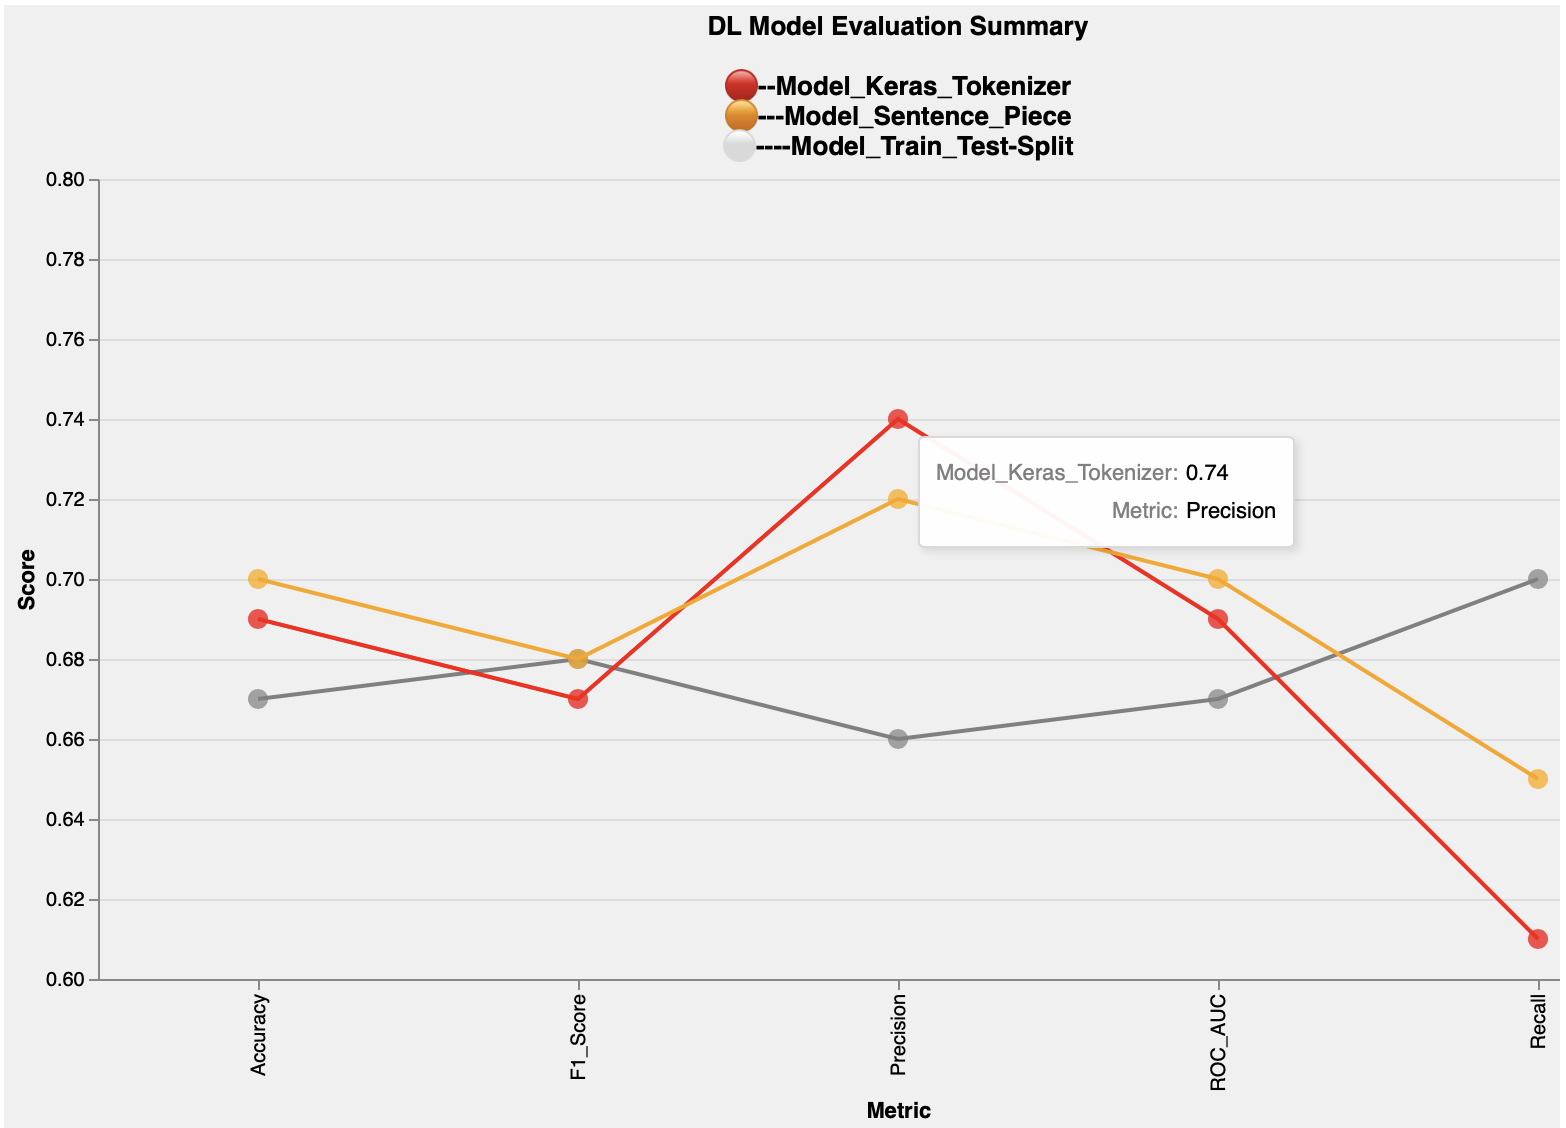

### Observation: 

1. CNN-BiGRU-Attention with both tokenizers offered comparable model accuracy and precision scores on the validation dataset. 
2. Model performance was extremely sensitive to hyperparameters such number of neurons, bidirectional layer and batch_size. 
3. Simple NN architecture with GridsearchCV was helpful in picking out epochs and batch_size for better run time.  

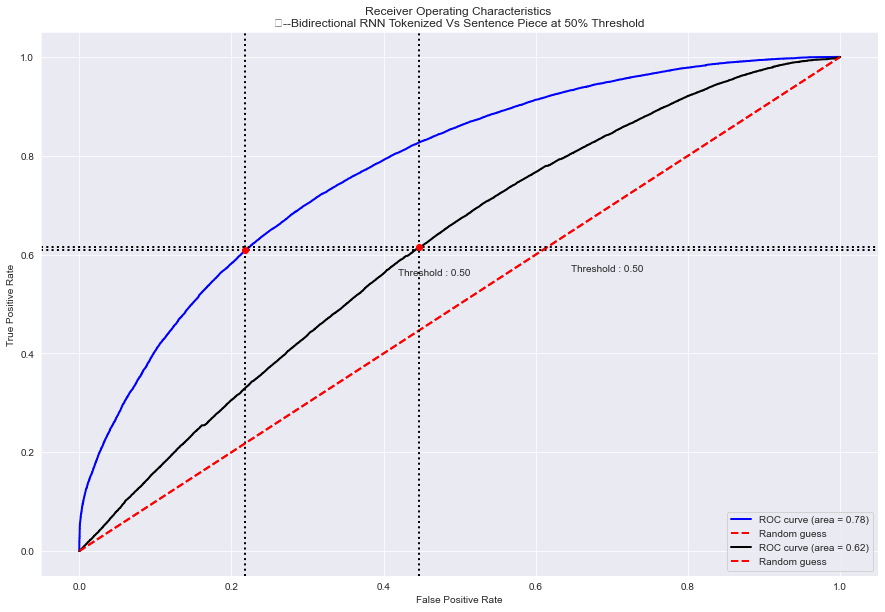

In [224]:
# Plot of ROC Curve:  
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
model_tkn = BinaryClassification(y_test, y_predproba_tok, labels=["Class 1", "Class 2"])
model_spm = BinaryClassification(y_test, y_predproba_sm, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
model_tkn.plot_roc_curve(c_roc_curve='blue', threshold = 0.5)
model_spm.plot_roc_curve()
_ = plt.title('Receiver Operating Characteristics \n Tokenized (Blue) Vs Sentence Piece at 50% Threshold')
plt.show()


# AUC ROC score for Extracted Random forest model is 80% at 50% threshold as shown by the blue curve. 

### Observation: 
1. Significant difference in ROC curve area between the two model, which was interesting to note and will require few more iterations.  